# Tutorial 2 - MicaSense library

This tutorial assumes you have gone through the [basic setup](./Micasense Image Processing Setup.html) and builds on the basic radiance, irradiance, and reflectance concepts and code covered in the [first tutorial](./MicaSense Image Processing Tutorial 1.html). 

In this tutorial, we will cover usage of the MicaSense python library to access images and groups of images.  Most of the processing details are hidden away in the library, but the library code is open and available in the git repository. 

# Library Components

In the first tutorial, we introduced `micasense.utils` which provided some helper functions for single image manipulation, and `micasense.plotutils` which provided some plotting helpers.

For this second tutorial, we are going to introduce the usage of the included micasense libraries for opening, converting, and displaying images. This will allow us to discuss and visualize results at a high level, while the underlying source code is available for those interested in the implementation details.  In some cases, the libraries themselves may be enough to implement a custom workflow without the need to re-implement or translate the code to another system or language.

The library code provides some basic classes to manage image data.  At the highest level is the `ImageSet`, which is able to load a list of files or recursively search a whole directory into data structures which are easy to access and manipulate.  `ImageSet`s are made up of `Capture`s, which hold the set of (usually 5) images as they are simultaneously gathered by the RedEdge camera.  Within `Capture`s are `Image`s, which hold a single image file and allow easy access to the image metadata.  The `Image` class also provides the ability to extract metadata from individual images and to convert individual images in similar ways to those described in the first tutorial. 

For the rest of this article, we will look at each of the objects available starting with the single `Image` object, and work our way up to the whole `ImageSet`.  Each section in this article is standalone, and can be copied into another workbook or edited in place to explore more of the functions associated with that object.

## micasense.Image

An image is the lowest level object. It represents the data in a single tiff file as taken by the camera.  `Image` objects expose a set of data retrieval methods which provide access to raw, radiance, and reflectance corrected images, and to undistort any of those images. Note that when retrieving image data from an `Image` object, the data is stored internally in the object, increasing the object's memory footprint. If operating on a large number of images, it may be necessary to release this data memory after each image is processed to limit the program memory footprint. This can be done by calling the `Image.clear_image_data()` method.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, time, os, datetime, glob
import micasense.image as image
import micasense.panel as panel
import micasense.capture as capture
import micasense.imageset as imageset
from ipywidgets import FloatProgress
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from platform import python_version

print(f"(Sys version) :|: {sys.version} :|:")
os.system("which python")
print(f"(Python version) :#: {python_version()} :#:")

(Sys version) :|: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)] :|:
(Python version) :#: 3.7.12 :#:


.\data\0000SET\000
.\data\0000SET\000\IMG_0000_4.tif


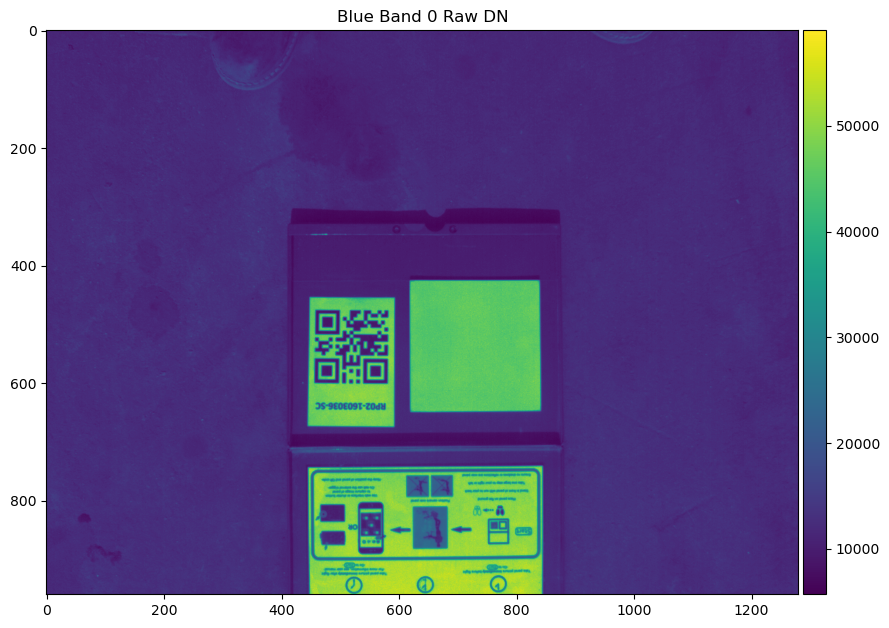

(<Figure size 900x675 with 2 Axes>,
 <AxesSubplot:title={'center':'Blue Band 0 Raw DN'}>)

In [4]:
# Method 01
# imagePath = os.path.join('.','data','0000SET','000')
# imageName = os.path.join(imagePath,'IMG_0000_4.tif')

# Method 02
# Linux filepath
# imagePath = os.path.expanduser(os.path.join('~','Downloads','RedEdge3'))
# Windows filepath
# imagePath = os.path.join('c:\\','Users','robso','Downloads','RedEdge3')
imagePath = os.path.join('.','data','0000SET','000')
print(imagePath)

imageName = glob.glob(os.path.join(imagePath,'IMG_0000_4.tif'))[0]
print(imageName)

image_path = os.path.join('.','data','0000SET','000','IMG_0000_1.tif')

img = image.Image(image_path)

img.plot_raw(figsize=(9,6.75),num=1)

### Accessing `Image` Metadata

Metadata for each image is available in the `Image.meta` parameter.  This object is a `micasense.Metadata` object and can be accessed directly for image specific metadata extraction. Below, we print the same metadata values as we did in Tutorial #1, but using direct access to the `Metadata` object parameters.

A notebook for experimenting with the `Image` class can be found [here](Images.html).

In [5]:
print('{0} {1} firmware version: {2}'.format(img.meta.camera_make(),
                                             img.meta.camera_model(), 
                                             img.meta.firmware_version()))
print('Exposure Time: {0} seconds'.format(img.meta.exposure()))
print('Imager Gain: {0}'.format(img.meta.gain()))
print('Size: {0}x{1} pixels'.format(img.meta.image_size()[0],
                                    img.meta.image_size()[1]))
print('Band Name: {0}'.format(img.meta.band_name()))
print('Center Wavelength: {0} nm'.format(img.meta.center_wavelength()))
print('Bandwidth: {0} nm'.format(img.meta.bandwidth()))
print('Capture ID: {0}'.format(img.meta.capture_id()))
print('Flight ID: {0}'.format(img.meta.flight_id()))

MicaSense RedEdge firmware version: v2.1.2-34-g05e37eb-local
Exposure Time: 0.0004725 seconds
Imager Gain: 1.0
Size: 1280x960 pixels
Band Name: Blue
Center Wavelength: 475 nm
Bandwidth: 20 nm
Capture ID: 5v25BtsZg3BQBhVH7Iaz
Flight ID: NtLNbVIdowuCaWYbg3ck


## micasense.Capture

The `Capture` class is a container for `Image`s which allows access to metadata common to the group of images. The internal `Image` objects are accessible via the `capture.images` properties, and images in this list are kept sorted by the `band` property.  Data which is different for each image can be accessed through composite methods, such as the `capture.dls_irradiance()` method, which returns a list of irradiances in band order.

.\data\0000SET\000
['.\\data\\0000SET\\000\\IMG_0000_1.tif', '.\\data\\0000SET\\000\\IMG_0000_2.tif', '.\\data\\0000SET\\000\\IMG_0000_3.tif', '.\\data\\0000SET\\000\\IMG_0000_4.tif', '.\\data\\0000SET\\000\\IMG_0000_5.tif']
len(file_list): 5


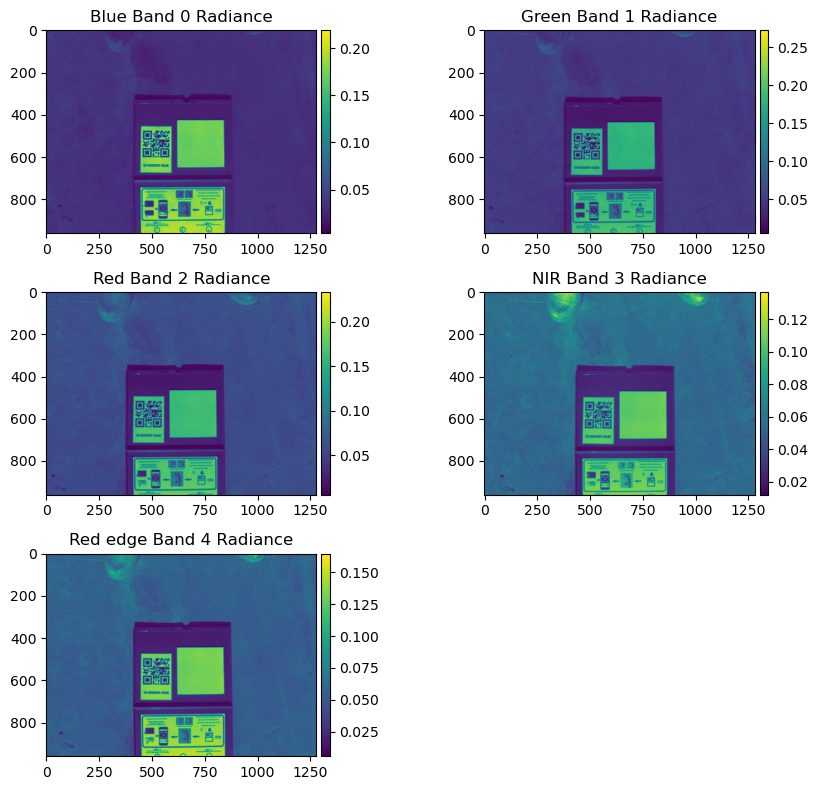

In [6]:
# Method 01
# imagePath = os.path.join('.','data','0000SET','000')
# imageName = os.path.join(imagePath,'IMG_0000_4.tif')

# Method 02
# Linux filepath
# imagePath = os.path.expanduser(os.path.join('~','Downloads','RedEdge3'))
# Windows filepath
# imagePath = os.path.join('c:\\','Users','robso','Downloads','RedEdge3')
images_path = os.path.join('.','data','0000SET','000')
print(images_path)

image_names = glob.glob(os.path.join(images_path,'IMG_0000_*.tif'))
print(image_names)

cap = capture.Capture.from_filelist(image_names)
# cap.plot_radiance(fig_size=(9,6.75),num=2)
cap.plot_radiance(fig_size=(9,8),num=2)

### Acessing `Capture` metadata

Metadata which is common to all captures can be accessed via methods on the `Capture` object.  Metadata which varies between the images of the capture, such as DLS information, is available as lists accessed from the capture object. 

<div class="alert alert-info">
  <strong>Note:</strong> The lists returned from metadata access on the `Capture` object are returned in `band_index` order.  All images within a capture are sorted by the image `band_index`, and all lists adhere to this ordering.  This ordering is consistent with the number at the end of each filename of a RedEdge image.
</div>

Below we plot the raw and tilt compensated DLS irradiance by center wavelength and by band name.


['Blue', 'Green', 'Red', 'NIR', 'Red edge']


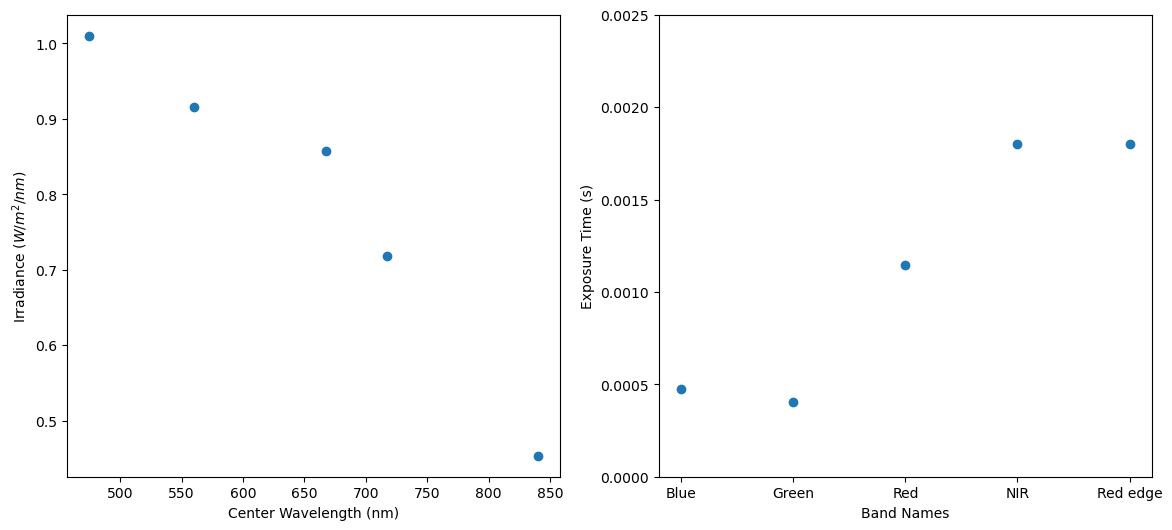

In [7]:
print(cap.band_names())
fig = plt.figure(figsize=(14,6),num=3)
plt.subplot(1,2,1)
plt.scatter(cap.center_wavelengths(), cap.dls_irradiance())
plt.ylabel('Irradiance $(W/m^2/nm)$')
plt.xlabel('Center Wavelength (nm)')
plt.subplot(1,2,2)
plt.scatter(cap.band_names(), [img.meta.exposure() for img in cap.images])
plt.xlabel('Band Names')
plt.ylim([0,2.5e-3])
plt.ylabel('Exposure Time (s)')
plt.show()

A notebook for experimenting with the `Capture` class can be found [here](Captures.html).

## micasense.Panel

The `Panel` class is a helper class which can automatically extract panel information from MicaSense calibrated reflectance panels by finding the QR code within an image and using the QR Code location and orientation information to find the lambertian panel area.  The class then allows extraction of statistics from the panel area such as mean raw values, mean radiance, standard deviation, and the number of saturated pixels in the panel region. The panel object can be included standalone, or used within the context of a `Capture` object.

<div class="alert alert-info">
  <strong>Note:</strong> For the automatic panel QR code finding functions of the library to work, zbar and it's python bindings must be installed. We have made every effort to ensure this fails gracefully if zbar isn't available. Unfortunately zbar is only available using Python 2.7, not Python 3.  If you're using Python 3.x, the code available in '/micasense/panel.py' shows how to find QR codes in images and to find the panel area from the QR location.  We're currently looking for Python QR code finding options that work across platforms and Python versions, let us know if you have one that supports location!
</div>

.\data\0000SET\000\IMG_0000_1.tif
[[[809, 613], [648, 615], [646, 454], [808, 452]], [[772, 623], [613, 625], [610, 464], [770, 462]], [[771, 651], [611, 653], [610, 492], [770, 490]], [[829, 658], [668, 659], [668, 496], [829, 496]], [[807, 632], [648, 634], [645, 473], [805, 471]]]

[[809, 613], [648, 615], [646, 454], [808, 452]]

Panel found: True
Panel serial: RP02-1603036-SC
QR Code Corners:
[[459 598]
 [582 599]
 [583 477]
 [462 476]]
region: [[809 613]
 [648 615]
 [646 454]
 [808 452]]
rev_panel_pts: [[613 809]
 [615 648]
 [454 646]
 [452 808]]
Panel mean raw pixel value: 45407.70132266995
Panel raw pixel standard deviation: 723.4386018440359
Panel region pixel count: 26008
Panel region saturated pixel count: 26008


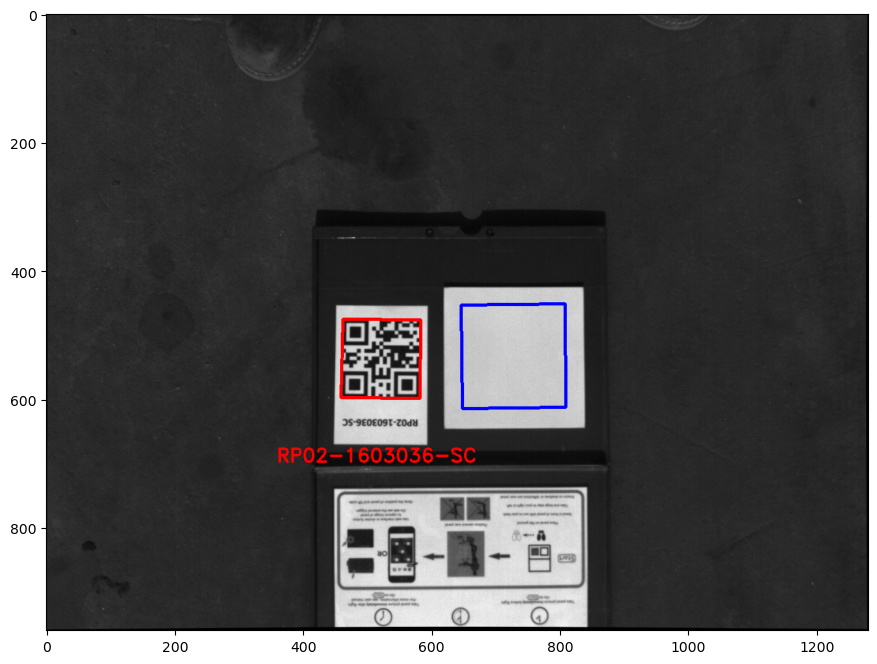

(<Figure size 900x675 with 1 Axes>, <AxesSubplot:>)

In [8]:
# Method 01
# imagePath = os.path.join('.','data','0000SET','000')
# imageName = os.path.join(imagePath,'IMG_0000_4.tif')

# Method 02
# Linux filepath
# imagePath = os.path.expanduser(os.path.join('~','Downloads','RedEdge3'))
# Windows filepath
# imagePath = os.path.join('c:\\','Users','robso','Downloads','RedEdge3')
image_path = os.path.join('.','data','0000SET','000','IMG_0000_1.tif')
print(image_path)

img = image.Image(image_path)
# panelCorners - if we dont have zbar installed to scan the QR codes, detect panel manually and 
panelCorners = [[[809,613],[648,615],[646,454],[808,452]],
                [[772,623],[613,625],[610,464],[770,462]],
                [[771,651],[611,653],[610,492],[770,490]],
                [[829,658],[668,659],[668,496],[829,496]],
                [[807,632],[648,634],[645,473],[805,471]]]
print(panelCorners)
print()
print(panelCorners[0])
print()
pnl = panel.Panel(img,panelCorners = panelCorners[0])
print("Panel found: {}".format(pnl.panel_detected()))
print("Panel serial: {}".format(pnl.serial))
print("QR Code Corners:\n{}".format(pnl.qr_corners()))
mean, std, count, saturated_count = pnl.raw()
print("Panel mean raw pixel value: {}".format(mean))
print("Panel raw pixel standard deviation: {}".format(std))
print("Panel region pixel count: {}".format(count))
print("Panel region saturated pixel count: {}".format(count))

pnl.plot(figsize=(9,6.75),num=4)

A notebook for experimenting with the `Panel` class can be found [here](Panels.html)

## micasense.ImageSet

An `ImageSet` contains a group of `Capture`s. The captures can be loaded from image object, from a list of files, or by recursively searching a directory for images.

Loading an `ImageSet` can be a time consuming process.  It uses python multithreading under the hood to maximize cpu usage on multi-core machines.

In [9]:
f = FloatProgress(min=0, max=1)
display(f)
def update_f(val):
    f.value=val


# Method 01
# imagePath = os.path.join('.','data','0000SET','000')
# imageName = os.path.join(imagePath,'IMG_0000_4.tif')
images_dir = os.path.join('.','data','0000SET')

# Method 02
# Linux filepath
# imagePath = os.path.expanduser(os.path.join('~','Downloads','RedEdge3'))
# Windows filepath
# imagePath = os.path.join('c:\\','Users','robso','Downloads','RedEdge3')
print(images_dir)

imgset = imageset.ImageSet.from_directory(images_dir, progress_callback=update_f)

for cap in imgset.captures:
    print ("Opened Capture {} with bands {}".format(cap.uuid,[str(band) for band in cap.band_names()]))

FloatProgress(value=0.0, max=1.0)

.\data\0000SET
Loading ImageSet from: .\data\0000SET


c:\imageprocessing\micasense\imageset.py:139: PendingDeprecationWarning: The progress_callback parameter will be deprecated in favor of use_tqdm
  category=PendingDeprecationWarning)


Opened Capture 5v25BtsZg3BQBhVH7Iaz with bands ['Blue', 'Green', 'Red', 'NIR', 'Red edge']
Opened Capture g2R43Qr5m7EeTFGbkh1W with bands ['Blue', 'Green', 'Red', 'NIR', 'Red edge']


## Extended ImageSet examples

A large group of images captured over a central California orchard are available for [download here](https://s3-us-west-2.amazonaws.com/sample.micasense.com/imageprocessing/RedEdgeImageSet.zip).

With this set extracted to a working folder, the [extended ImageSet example](./ImageSets.html) notebook provides more usages of ImageSet data.

# Conclusion

In this tutorial, we have introduced the MicaSense library and provided some examples of opening Images, Captures, and ImageSets, as well as detecting and extracting panel information from images.

The next tutorial covers basic usage of DLS information, and is available [here](./MicaSense%20Image%20Processing%20Tutorial%203.html)

---
Copyright (c) 2017-2019 MicaSense, Inc.  For licensing information see the [project git repository](https://github.com/micasense/imageprocessing)